<a id="title"></a>
# How to use `wfc3_dash` on DASH data
***
## Learning Goals:
By the end of this tutorial, you will:
- Create difference files, association tables, and segmentation maps using `wfc3_dash`.
- Subtract background and fix cosmic rays from newly generated FLTs.
- Align reads to each other for a final product.

## Table of Contents:
[Introduction](#introduction) <br>
[1. Imports](#imports) <br>
[2. Download relevant data](#downloads) <br>
[3. Run DASH](#DASH) <br>
- [3.1 Create DashData object](#object) <br>
- [3.2 Create difference files from reads](#diff_files) <br>
- [3.3 Create an association table](#asn_table) <br>
- [3.4 Create a segmentation map](#seg_map) <br>
- [3.5 Subtract background from the difference files](#subtract_ext) <br>
- [3.6 Fix cosmic rays](#cosmic_rays) <br>
- [3.7 Align reads to each other](#align_each_other) <br>

[4. Plot original IMA vs. DASH pipeline science result](#plot) <br>
[5. Conclusions](#conclusions) <br>
[Additional Resources](#resources) <br>
[About the Notebook](#about) <br>
[Citations](#cite) <br>

 <a id='introduction'></a>
## Introduction

This notebook is the first in a new Drift And SHift (DASH) pipeline workflow developed to ease the process of reducing DASH data. The pipeline is customizable, able to be changed according to scientific goals of the user, and this first tutorial walks the user from data download to a finished product ready for science analysis. For more information, see [Momcheva et. al 2016](https://arxiv.org/pdf/1603.00465.pdf) and [WFC3 ISR 2021-01](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2021/2021-02.pdf).

<a id='imports'></a>
## 1. Imports
This notebook assumes you have created the virtual environment in [WFC3 Library's](https://github.com/spacetelescope/WFC3Library) installation instructions.

We import:
- *os* for setting environment variables
- *glob* for querying through directories
- *numpy* for handling array functions
- *matplotlib.pyplot* for plotting data
- *astropy* for astronomy related functions
- *astroquery.Observations* for downloading data
- *drizzlepac.astrodrizzle* for combining images
- *reduce_dash* for reducing DASH data

In [1]:
%matplotlib notebook

import os
from glob import glob

import numpy as np
import matplotlib.pyplot as plt 

from astropy.io import fits 
from astropy.table import Table
from astropy.io import ascii
from astroquery.mast import Observations

from drizzlepac import astrodrizzle 

from reduce_dash import DashData



The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


<a id='downloads'></a>
## 2. Download relevant data

Retrieve the table of observations associated with 15238.

In [2]:
obsTable = Observations.query_criteria(proposal_id=['15153'], obs_id=['IDN113*'])

Get the full list of products associated to the table and restrict the list to IMA files.

In [3]:
product_list = Observations.get_product_list(obsTable)
BM = (product_list['productSubGroupDescription']  == 'IMA') 
product_list = product_list[BM]

product_list.show_in_notebook(display_length=5)

Choose a single exposure file to work on. In this example, we choose the first exposure. To create usable data, you will have to follow this work flow on all individual IMA files in your dataset.

In [4]:
myID = product_list['obsID'][0:1]
print(myID)

 obsID  
--------
26071412


Download the IMA and FLT files for that exposure. The standard pipeline-FLT will be used for comparison with the detrended final product.

In [5]:
download = Observations.download_products(myID,mrp_only=False,productSubGroupDescription=['IMA','FLT'])

INFO: Found cached file ./mastDownload/HST/idn113owq/idn113owq_ima.fits with expected size 126201600. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/idn113owq/idn113owq_flt.fits with expected size 16516800. [astroquery.query]


Display the results of the download operation.

In [6]:
download

<Table length=2>
                   Local Path                    Status  Message  URL  
                     str47                        str8    object object
----------------------------------------------- -------- ------- ------
./mastDownload/HST/idn113owq/idn113owq_ima.fits COMPLETE    None   None
./mastDownload/HST/idn113owq/idn113owq_flt.fits COMPLETE    None   None

Read the files that were just downloaded locally. In addition, have the path be just the rootname, i.e. without the file extension.

In [7]:
localpathtofile = download['Local Path'][1][:-8]
localpathtofile

original_ima = fits.open(localpathtofile+'ima.fits')
original_flt = fits.open(localpathtofile+'flt.fits')
original_ima.info()

Filename: ./mastDownload/HST/idn113owq/idn113owq_ima.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     262   ()      
  1  SCI           1 ImageHDU        81   (1024, 1024)   float32   
  2  ERR           1 ImageHDU        43   (1024, 1024)   float32   
  3  DQ            1 ImageHDU        35   (1024, 1024)   int16   
  4  SAMP          1 ImageHDU        30   ()      
  5  TIME          1 ImageHDU        30   ()      
  6  SCI           2 ImageHDU        81   (1024, 1024)   float32   
  7  ERR           2 ImageHDU        43   (1024, 1024)   float32   
  8  DQ            2 ImageHDU        35   (1024, 1024)   int16   
  9  SAMP          2 ImageHDU        30   ()      
 10  TIME          2 ImageHDU        30   ()      
 11  SCI           3 ImageHDU        81   (1024, 1024)   float32   
 12  ERR           3 ImageHDU        43   (1024, 1024)   float32   
 13  DQ            3 ImageHDU        35   (1024, 1024)   int16   
 14  SAMP          

Print the number of samples and plot the individual reads of the IMA file.

**Note: the individual 'SCI' extensions are stored in reverse order, with 'SCI', 1 corresponding to the last read.**

NSAMP 12


<IPython.core.display.Javascript object>


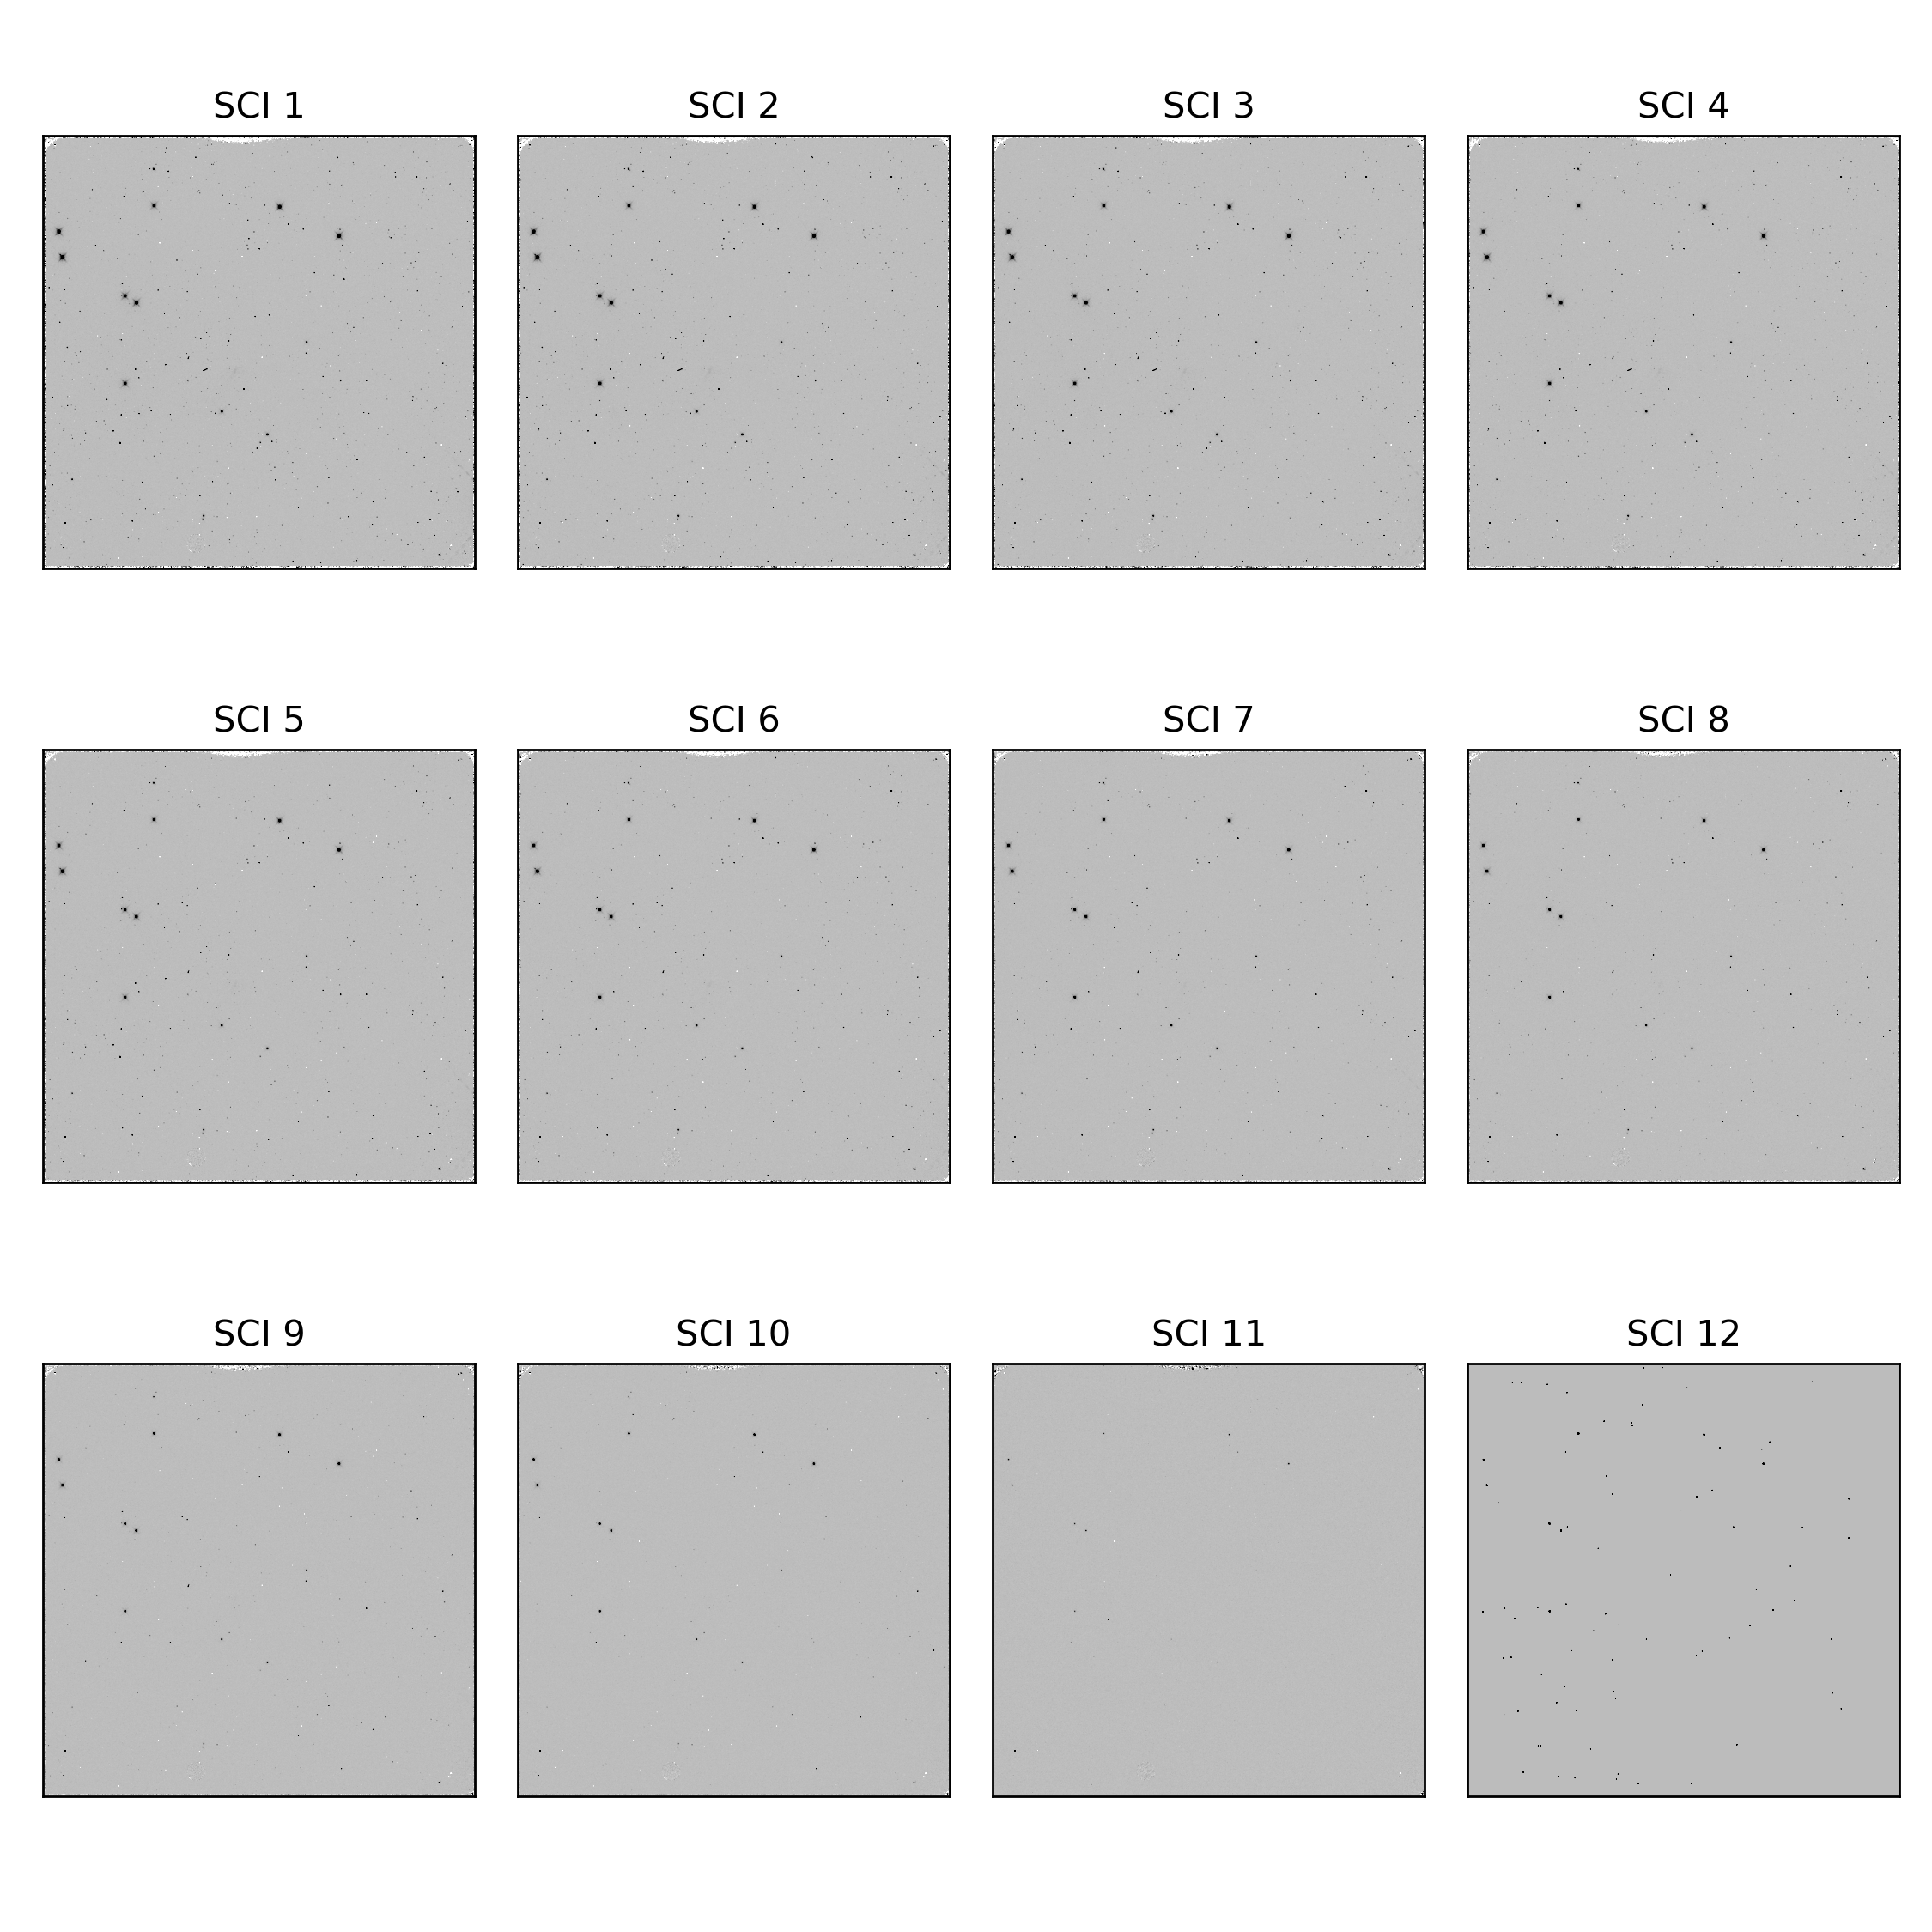

In [8]:
nsamp = original_ima[0].header['NSAMP']
print('NSAMP',nsamp)

fig,axarr = plt.subplots((nsamp+3)//4,4, figsize=(9,3*((nsamp+3)//4)))

for i in range(1,4*((nsamp+3)//4)+1):

    row = (i-1)//4
    col = (i-1)%4
    if (i <= nsamp):
        immed = np.nanmedian(original_ima['SCI',i].data)
        stdev = np.nanstd(original_ima['SCI',i].data)
        axarr[row,col].imshow(original_ima['SCI',i].data,clim=[immed-.3*stdev,immed+.5*stdev],cmap='Greys',origin='lower')
        axarr[row,col].set_title('SCI '+str(i))
        axarr[row,col].set_xticks([]) 
        axarr[row,col].set_yticks([]) 
    else:
        fig.delaxes(axarr[row,col])

fig.tight_layout()

<a id="query"></a>
## 3. Query CRDS for reference files 

Before running `reduce_dash`, we need to set some environment variables for several subsequent calibration tasks.

We will point to a subdirectory called `crds_cache/` using the IREF environment variable. The IREF variable is used for WFC3 reference files. Other instruments use other variables, e.g., JREF for ACS.

In [9]:
os.environ['CRDS_SERVER_URL'] = 'https://hst-crds.stsci.edu'
os.environ['CRDS_SERVER'] = 'https://hst-crds.stsci.edu'
os.environ['CRDS_PATH'] = './crds_cache'
os.environ['iref'] = 'iref/'
if not os.path.exists('iref'):
    os.mkdir('iref')

The code block below will query CRDS for the best reference files currently available for these datasets and update the header keywords to point to these new files. We will use the Python package `os` to run terminal commands. In the terminal, the line would be:

```crds bestrefs --files [filename] --sync-references=1 --update-bestrefs```

...where 'filename' is the name of your fits file.

In [10]:
ima_files = glob('idn113*_ima.fits') 

for file in ima_files:
    command_line_input = 'crds bestrefs --files {:} --sync-references=1 --update-bestrefs'.format(file)
    os.system(command_line_input)

<a id='DASH'></a>
## 3. Run DASH
Run the DASH pipeline for a single exposure. This procedure showcases the capabilities and customization options of the DASH pipeline.

**Note: the following will only work if you are using the notebooks inside of the Notebook directory. `wfc3_dash` submodule will be properly packaged and installed within the `wfc3_tools` module sometime in the future.**

If you move the notebooks and want to use them elsewhere, you can still provide a `temp_path` to the dash codes and remove the comments below. 

In [11]:
#import sys

#module_path = os.path.abspath(os.path.join('..'))
#if module_path not in sys.path:
#    sys.path.append(module_path)

#tmp_path = ".../wfc3_dash/wfc3_dash"
#if tmp_path not in sys.path:
#    sys.path.append(tmp_path)

<a id='object'></a>
### 3.1 Create DashData object

We use the both IMA and FLT extensions of our local image to create a DashData object.

In [12]:
myDash = DashData(localpathtofile+'ima.fits', flt_file_name=localpathtofile+'flt.fits')
print(myDash.root)

idn113owq


<a id='diff_files'></a>
### 3.2 Create difference files from reads

A difference (diff) file contains the counts accumulated between two reads of the IMA file. The diff files are written to disk in a directory named `./diff` under the current working directory (cwd). In creating diff files from the readouts of the IMA, the first difference, between the 1-st and 0-th read is ignored because of its very short exposure time of 2.9 seconds, resulting in a noisy image. 

In order to create the best possible results, the `split_ima()` method uses the `bestrefs` function from [CRDS](https://hst-crds.stsci.edu/) to ensure all reference files are up to date and available.

In [13]:
myDash.split_ima()

Writing idn113owq_01_diff.fits
Writing idn113owq_02_diff.fits
Writing idn113owq_03_diff.fits
Writing idn113owq_04_diff.fits
Writing idn113owq_05_diff.fits
Writing idn113owq_06_diff.fits
Writing idn113owq_07_diff.fits
Writing idn113owq_08_diff.fits
Writing idn113owq_09_diff.fits
Writing idn113owq_10_diff.fits


Print the number of diff files and plot the diff files.

Number of diff files 10


<IPython.core.display.Javascript object>


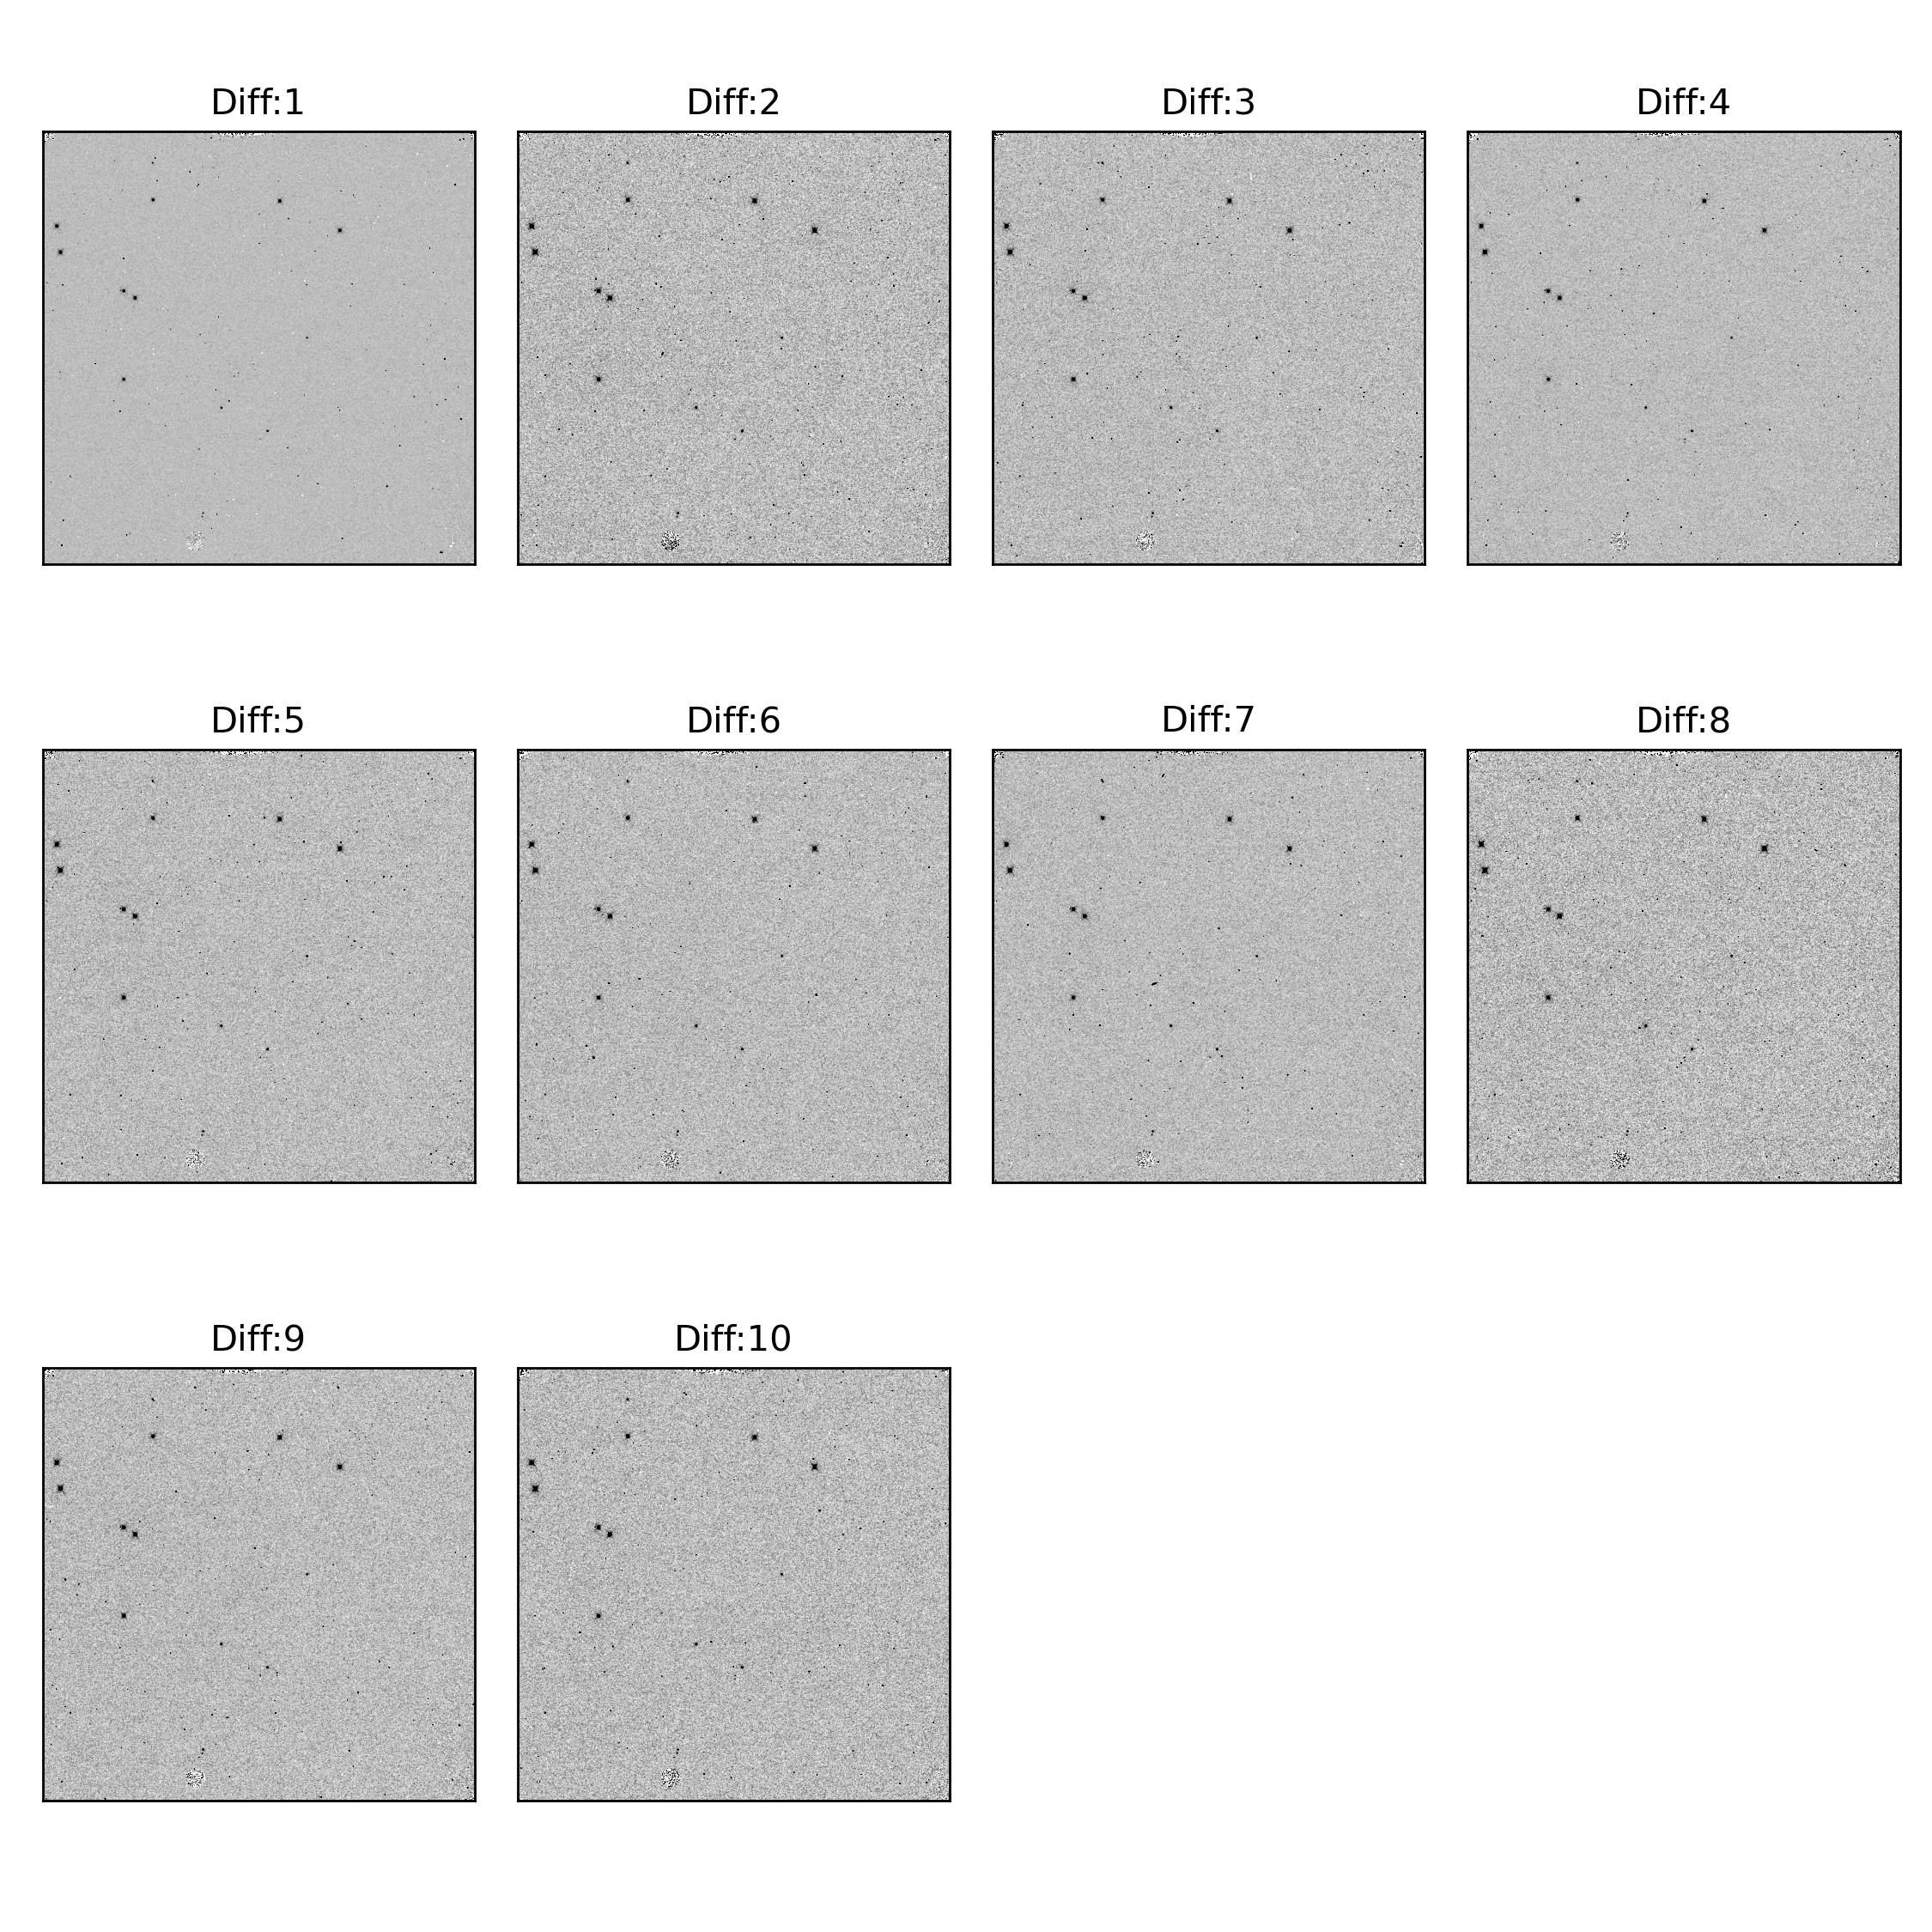

In [14]:
ndiff = len(myDash.diff_files_list)
print('Number of diff files',ndiff)

if ndiff > 4: 
    fig,axarr = plt.subplots((ndiff+3)//4,4, figsize=(9,3*((ndiff+3)//4)))

    for i in range(4*((ndiff+3)//4)):

        row = (i)//4
        col = (i)%4
        if (i < ndiff):
            diff_i = fits.open(myDash.diff_files_list[i]+'_diff.fits')
            immed = np.nanmedian(diff_i['SCI'].data)
            stdev = np.nanstd(diff_i['SCI'].data)
            axarr[row,col].imshow(diff_i['SCI'].data,clim=[immed-.3*stdev,immed+.5*stdev],cmap='Greys',origin='lower')
            axarr[row,col].set_title('Diff:'+str(i+1))
            axarr[row,col].set_xticks([]) 
            axarr[row,col].set_yticks([]) 
        else:
            fig.delaxes(axarr[row,col])
else:
    fig,axarr = plt.subplots(1,ndiff,figsize=(15,15))
    for i in range(ndiff):
        immed = np.nanmedian(diff_i['SCI'].data)
        stdev = np.nanstd(diff_i['SCI'].data)
        diff_i = fits.open(myDash.diff_files_list[i]+'_diff.fits')
        axarr[i].imshow(diff_i['SCI'].data,clim=[immed-.3*stdev,immed+.5*stdev],cmap='Greys',origin='lower')
        axarr[i].set_title('Diff:'+str(i+1))
        axarr[i].set_xticks([]) 
        axarr[i].set_yticks([]) 

fig.tight_layout()

<a id='asn_table'></a>
### 3.3 Create an association table

This file mimics a typical association file for dithered exposures, which is used by AstroDrizzle to align and stack multiple exposures taken at the same sky position with small dithers. 

We exploit the fact that a WFC3/IR exposure taken under gyro control can be effectively split into individual pseudo-exposures (the diff images we created in [Section 3.2](#diff_files)). From there, AstroDrizzle can treat such pseudo-expsoures as individual dithers, and combine them into a single exposure.

In [18]:
myDash.make_pointing_asn()

Show the content of the asn file, which was created in `./diff`.

In [19]:
asn_filename = 'diff/{}_asn.fits'.format(myDash.root)
asn_table = Table(fits.getdata(asn_filename, ext=1))
asn_table.show_in_notebook()

<a id="seg_map"></a>
### 3.4 Create a segmentation map

Create segmentation map from original FLT image to assist with background subtraction and fixing of cosmic ray flags using `create_seg_map()`. This method makes a directory called `./segmentation_maps`, which holds the outputs.

In [20]:
myDash.create_seg_map()

Plot segmentation map.

<IPython.core.display.Javascript object>


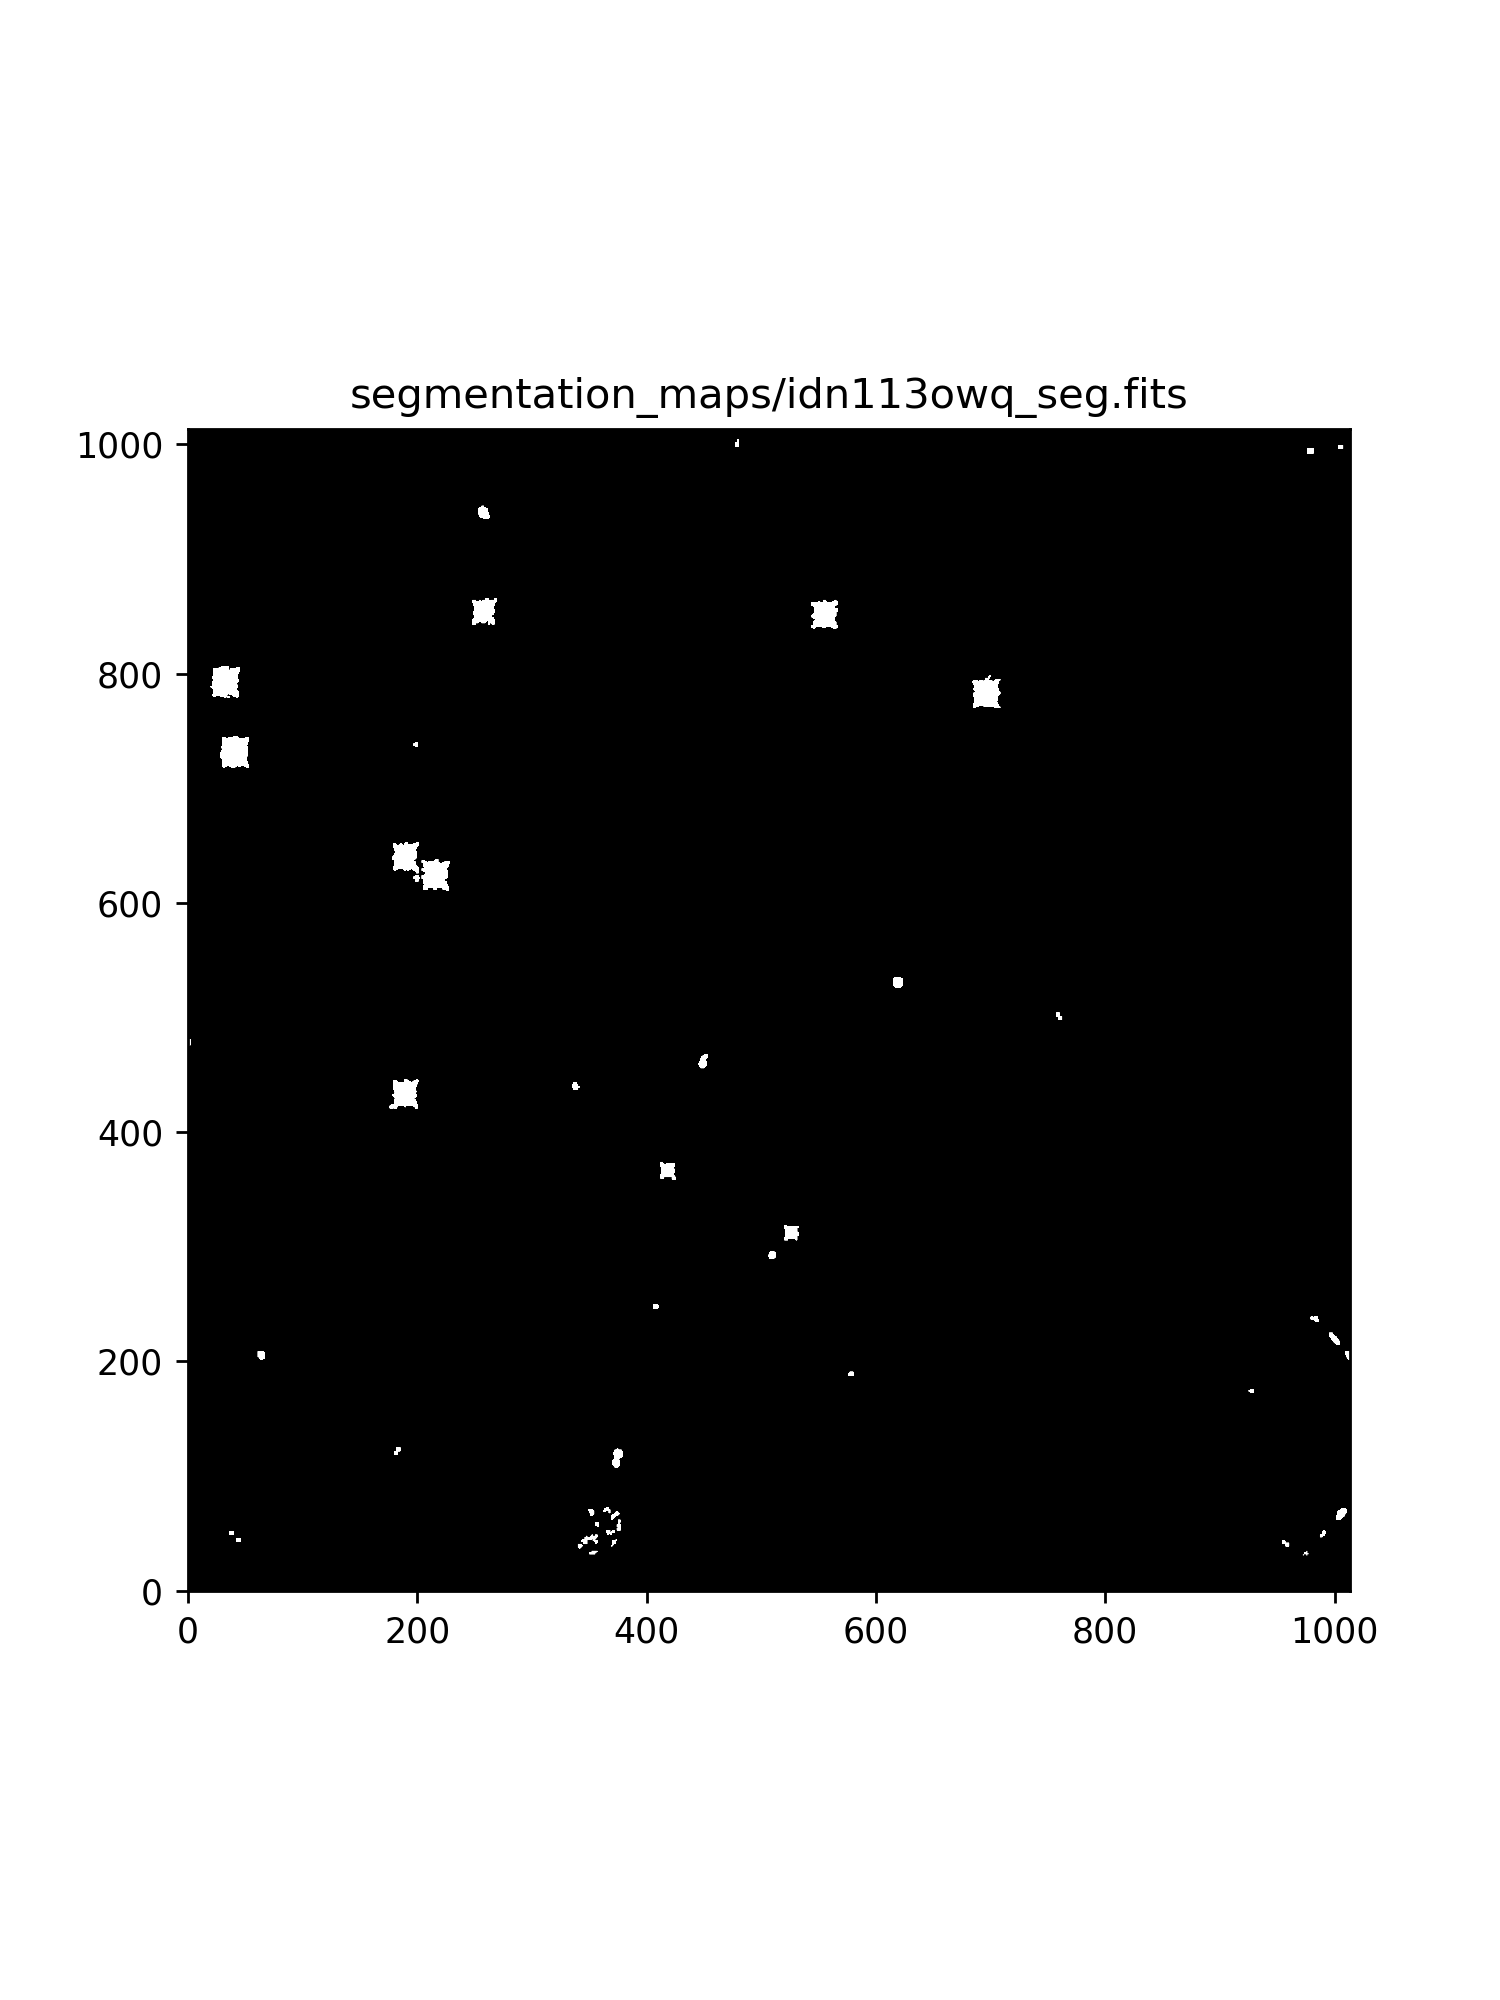

In [21]:
rootname = myDash.root
segmap_name = ('segmentation_maps/'+ rootname + '_seg.fits')
segmap = fits.getdata(segmap_name)

fig = plt.figure(figsize=(6, 8))
plt.title(segmap_name)
plt.imshow(segmap, origin='lower', vmin=0, vmax=1, cmap='Greys_r')

Print and read source list.

In [22]:
sourcelist_name = ('segmentation_maps/' + rootname + '_source_list.dat')
sourcelist = ascii.read(sourcelist_name)
print(sourcelist)

 id xcentroid ycentroid sky_centroid ...  cxx   cxy    cyy          gini       
--- --------- --------- ------------ ... ----- ------ ----- -------------------
  1    974.39      32.3         None ...  0.89  -0.04  1.34 0.16653278150328507
  2    353.15     33.32         None ...  0.65  -3.77  8.87  0.7867038836629328
  3    341.41     38.58         None ... 17.65  32.63 19.09  0.8948346268929391
  4    370.95      41.8         None ...  2.14  -1.05  0.86  0.5705605608475748
  5     956.9     40.67         None ...   3.0   8.24  6.74   0.860210826472494
  6    350.41      45.0         None ...  0.08  -0.09  0.28  0.6389220614333264
  7      43.7      44.0         None ...  3.31  -0.11 10.75   0.937906715176082
  8    989.07     49.21         None ...  1.24  -1.32  0.76 0.24519402666004073
  9      37.6     50.01         None ...  3.36   1.04 12.69  0.8632069804754984
 10    367.82     51.15         None ...  0.25  -0.45   2.8   0.672086461284491
...       ...       ...          ... ...

Let's create a segmentation map and source list from the difference files. We need to make source lists from our difference files created from the IMA so that `TweakReg` can better align these difference files to catalogs, each other, etc.

First, generate a list of difference files that contain the full path name.

In [23]:
diffpath = os.path.dirname(os.path.abspath('diff/{}_*_diff.fits'.format(rootname)))
cat_images = sorted([os.path.basename(x) for x in glob('diff/{}_*_diff.fits'.format(rootname))])
sc_diff_files = [diffpath + '/' + s for s in cat_images]

Then, create a difference segmentation map using `diff_seg_map()` and the diff files.

In [24]:
myDash.diff_seg_map(cat_images=sc_diff_files)

Plot the segmentation map from a diffrence files.

<IPython.core.display.Javascript object>


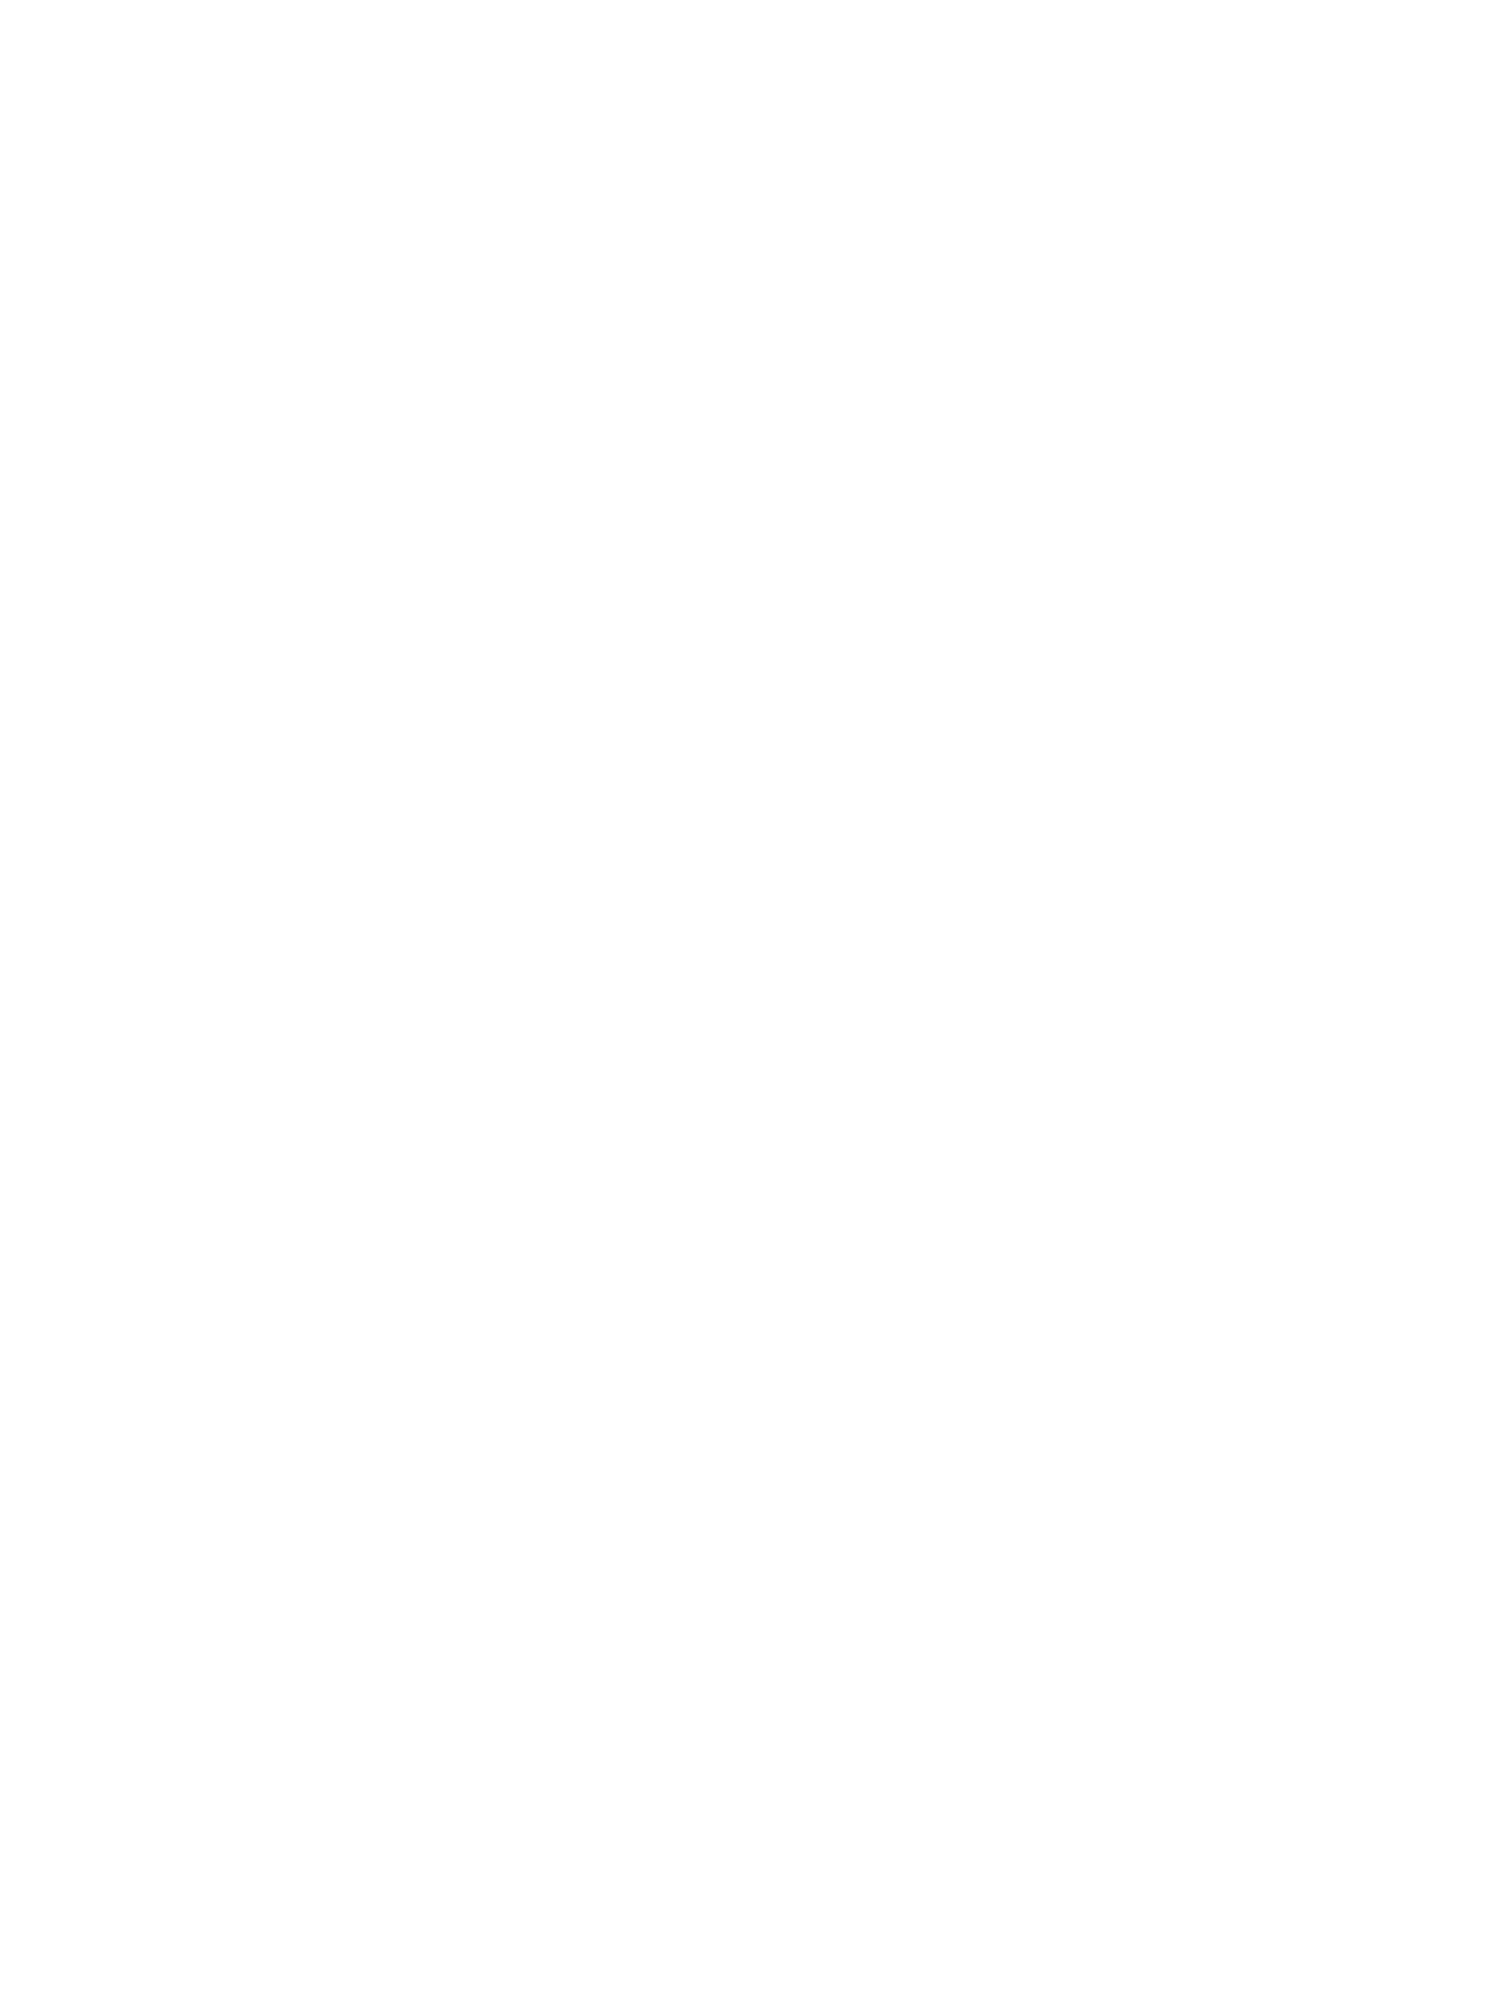

In [25]:
segmap_name = ('segmentation_maps/' + rootname + '_03_diff_seg.fits')
segmap = fits.getdata(segmap_name)
fig = plt.figure(figsize=(6, 8))
plt.title(segmap_name)
plt.imshow(segmap, origin='lower', vmin=0, vmax=1, cmap='Greys_r')

<a id='subtract_ext'></a>
### 3.5 Subtract background from difference files

Subtract background from the individual reads taken from the original IMA file using the DRZ and SEG images produced in the background subtraction of the original FLT. 

By default, `subtract_background_reads()` will subtract the background and write it to the header. By setting `subtract=False`, the background will not be subtracted and will only be written to the header. In addition, setting `reset_stars_dq=True` will reset cosmic rays within objects to 0 since the centers of the stars are flagged.

In [26]:
myDash.subtract_background_reads()

Background subtraction, diff/idn113owq_01_diff.fits:  0.017747754231095314
Background subtraction, diff/idn113owq_02_diff.fits:  0.04094477370381355
Background subtraction, diff/idn113owq_03_diff.fits:  0.037752024829387665
Background subtraction, diff/idn113owq_04_diff.fits:  0.033538613468408585
Background subtraction, diff/idn113owq_05_diff.fits:  0.03194118291139603
Background subtraction, diff/idn113owq_06_diff.fits:  0.0396038182079792
Background subtraction, diff/idn113owq_07_diff.fits:  0.027749817818403244
Background subtraction, diff/idn113owq_08_diff.fits:  0.020428670570254326
Background subtraction, diff/idn113owq_09_diff.fits:  0.04580425098538399
Background subtraction, diff/idn113owq_10_diff.fits:  0.009711330756545067


<a id='cosmic_rays'></a>
### 3.6 Fix cosmic rays

Now, we can use `fix_cosmic_rays()` to reset cosmic rays within the segmentation maps of objects and use [L.A.Cosmic](https://arxiv.org/pdf/astro-ph/0108003.pdf) to find them again.

In [27]:
myDash.fix_cosmic_rays()

Starting 4 L.A.Cosmic iterations
Iteration 1:
13 cosmic pixels this iteration
Iteration 2:
8 cosmic pixels this iteration
Iteration 3:
8 cosmic pixels this iteration
Iteration 4:
8 cosmic pixels this iteration


<a id='align_each_other'></a>
### 3.7 Align reads to each other
Align reads from the IMA to one another by aligning each difference file to the first diff file.

Listed below are all the parameters available to `myDash.align()`. `align()` uses `TweakReg` to update the WCS information in the headers of the diff files, then drizzles the images together using `AstroDrizzle`. There are more parameters available to users when working with `TweakReg` and `AstroDrizzle` that could be an integral part of the workflow for users of DASH. The example below lists the default values set for every input:

``myDash.align(self, subtract_background = True, 
            align_method = None, 
            ref_catalog = None, 
            create_diff_source_lists = True,
            updatehdr = True, 
            updatewcs = True, 
            wcsname = 'DASH', 
            threshold = 50., 
            cw = 3.5, 
            searchrad = 20., 
            astrodriz = True, 
            cat_file = 'catalogs/diff_catfile.cat',
            drz_output = None, 
            move_files = False)``
            
Refer to documentation to customize parameters for [TweakReg](https://drizzlepac.readthedocs.io/en/latest/tweakreg.html) and [AstroDrizzle](https://drizzlepac.readthedocs.io/en/latest/astrodrizzle.html). 

Note: the error `UnboundLocalError: local variable 'sig' referenced before assignment` can be solved by lowering threshold parameter.

In [28]:
myDash.align(threshold = 10.,searchrad = 20.,updatehdr=False, updatewcs=False, astrodriz=False)

Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/idn113owq_01_diff.fits:  -0.011906830593943596
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/idn113owq_02_diff.fits:  -0.02596171200275421
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/idn113owq_03_diff.fits:  -0.024061452597379684
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/idn113owq_04_diff.fits:  -0.022234292700886726
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/idn113owq_05_diff.fits:  -0.020415615290403366
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/idn113owq_06_diff.fits:  -0.025408558547496796
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/idn113owq_07_diff.fits:  -0.017570324242

TypeError: unsupported operand type(s) for /: 'NoneType' and 'float'

TypeError: unsupported operand type(s) for /: 'NoneType' and 'float'

Print the shifts file to analyze how well the alignment went. Do not update header until shifts, as seen in the `xrms` and `yrms` columns, are satisfactory. Further information about the outputs in the shift file and what is 'satisfactory' can be found in the [Drizzlepac Handbook](https://hst-docs.stsci.edu/drizzpac).

In [33]:
shift_file = glob('shifts/shifts_*.txt')
shift_file_name = shift_file[0]


shift_tab = Table.read(shift_file_name,
                       format='ascii.no_header',
                       names=['file','dx','dy','rot','scale','xrms','yrms'])

formats = ['.2f', '.2f', '.3f', '.5f', '.2f', '.2f']
for i, col in enumerate(shift_tab.colnames[1:]):
    shift_tab[col].format = formats[i]
shift_tab

<Table length=10>
                                     file                                      ...
                                    str78                                      ...
------------------------------------------------------------------------------ ...
/Users/cmartlin/Desktop/WFC3Library/notebooks/dash/diff/idn107jhq_01_diff.fits ...
/Users/cmartlin/Desktop/WFC3Library/notebooks/dash/diff/idn107jhq_02_diff.fits ...
/Users/cmartlin/Desktop/WFC3Library/notebooks/dash/diff/idn107jhq_03_diff.fits ...
/Users/cmartlin/Desktop/WFC3Library/notebooks/dash/diff/idn107jhq_04_diff.fits ...
/Users/cmartlin/Desktop/WFC3Library/notebooks/dash/diff/idn107jhq_05_diff.fits ...
/Users/cmartlin/Desktop/WFC3Library/notebooks/dash/diff/idn107jhq_06_diff.fits ...
/Users/cmartlin/Desktop/WFC3Library/notebooks/dash/diff/idn107jhq_07_diff.fits ...
/Users/cmartlin/Desktop/WFC3Library/notebooks/dash/diff/idn107jhq_08_diff.fits ...
/Users/cmartlin/Desktop/WFC3Library/notebooks/dash/diff/idn107jhq_09_diff.fits ...
/Users/cmartlin/Desktop/WFC3Library/notebooks/dash/diff/idn107jhq_10_diff.fits ...

Let's align our images with a threshold of 20, and update the headers and WCS information.

In [27]:
myDash.align(threshold = 0.5,searchrad = 10.,updatehdr=False, updatewcs=False, astrodriz=False)

Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/idn113owq_01_diff.fits:  -0.011906830593943596
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/idn113owq_02_diff.fits:  -0.02596171200275421
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/idn113owq_03_diff.fits:  -0.024061452597379684
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/idn113owq_04_diff.fits:  -0.022234292700886726
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/idn113owq_05_diff.fits:  -0.020415615290403366
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/idn113owq_06_diff.fits:  -0.025408558547496796
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/idn113owq_07_diff.fits:  -0.017570324242

TypeError: unsupported operand type(s) for /: 'NoneType' and 'float'

TypeError: unsupported operand type(s) for /: 'NoneType' and 'float'

<a id='plot'></a>
## 4. Plot original IMA and DASH pipeline science result

Plot the final DRZ image and compare to the original IMA.

In [28]:
sci_name = myDash.root + '_drz_sci.fits'
og_flt_name = 'mastDownload/HST/' + myDash.root + '/' + myDash.root + '_ima.fits'
sci = fits.getdata(sci_name)
og_flt = fits.getdata(og_flt_name)

fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_subplot(1,2,2)
ax2 = fig.add_subplot(1,2,1)

ax1.set_title('DASH Pipeline Reduced Science File')
ax2.set_title('Original IMA (not reduced using pipeline)')

ax1.set_xlim(-10,1120)
ax2.set_xlim(-10,1120)

ax1.set_ylim(-10,1050)
ax2.set_ylim(-10,1050)

ax1.imshow(sci, vmin=0, vmax=40, cmap='Greys_r', origin='lower')
ax2.imshow(og_flt, vmin=0, vmax=40, cmap='Greys_r', origin='lower')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'idn113owq_drz_sci.fits'

<a id="conclusions"></a>
## 5. Conclusions

Thank you for walking through this notebook. Now using WFC3 data, you should be more familiar with:

- Creating difference files, association tables, and segmentation maps using `wfc3_dash`.
- Subtracting background and fixing cosmic rays from newly generated FLTs.
- Aligning reads to each other for a final product.

#### Congratulations, you have completed the notebook!

<a id="resources"></a>
## Additional Resources
Below are some additional resources that may be helpful. Please send any questions through the [HST Helpdesk](https://stsci.service-now.com/hst).

- [WFC3 Website](https://www.stsci.edu/hst/instrumentation/wfc3)
- [WFC3 Instrument Handbook](https://hst-docs.stsci.edu/wfc3ihb)
- [WFC3 Data Handbook](https://hst-docs.stsci.edu/wfc3dhb)
    - see sections 9.5.4 for reference to this notebook
    
<a id="about"></a>
## About this Notebook

**Authors:** Catherine Martlin; WFC3 Instrument Team

**Updated on:** 2021-10-07

<a id="cite"></a>
## Citations

If you use `numpy`, `matplotlib`, `astropy`, `astroquery`, or `drizzlepac` for published research, please cite the
authors. Follow these links for more information about citing the libraries below:

* [Citing `numpy`](https://www.scipy.org/citing.html#numpy)
* [Citing `matplotlib`](https://www.scipy.org/citing.html#matplotlib)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `astroquery`](https://astroquery.readthedocs.io/en/latest/license.html)
* [Citing `drizzlepac`](https://drizzlepac.readthedocs.io/en/latest/LICENSE.html)

***
[Top of Page](#title)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 